In [1]:
import gym
import random as r
import os
import neat
import msvcrt as m
from sys import exit
import visualize

# Building the environment for the cheetah
env = gym.make('HalfCheetah-v2') #This is a global definition

#load the config file
config_path = os.path.join('ctrnn_config.txt')

time_const = 1.0


running build_ext


# Functions to connect the brain to the environment, run the brain and assess the effectiveness

In [2]:
def connect_brain(nLimbs, nCycles, net, render = False):
    '''
    Connect brain takes arguments:
    number of limbs = 6 for cheetah sausage
    number of cycles = run time for each NN to control the cheetah
    net = the CTRNN object
    render = flag to render the simulation to screen    
    
    Connecting the brain effectively feeds the CTRNN input nodes with the state of the environment, 
    and feeds the environment with the output nodes of the CTRNN
    '''
    
    # Reseting the cheetah environment.
    # This sets the cheetah to this starting point state
    env.reset()
    
    # Initialise an empty set with the number of control inputs going to mujoco
    x = [] 
    for i in range(nLimbs):
        x.append(0)
    
    # After each step of the envronment running, a result is returned that contains:
    # observation for the CTRNN brain to see that is fed to the CTRNN input
    # reward = the distance traveled during that cycle of the simulation with a maximum goal
    # Result needs to be initialised (with a set of controls set to 0) to be fed to the neural network
    
    result = env.step(x) 
    observation = result [0]
    reward = result [1]
    
    # Initializing the fitnesses which is just a collection of the rewards from each state
    # the cheetah moves to
    fitnesses = []
    fitness = int
    
    # control is the set of output nodes from the NN
    control = net.advance(observation, time_const, time_const) #0th observation to initialise control
    
    for i in range(nCycles): 
        # The CTRNN is activated by giving observation to the input nodes, and storing the output nodes in control
        control = net.advance(observation, time_const, time_const)
        
        # This loop creates a delay between the NN brain and the environment body.
        # This simulates the natural delay between signal and action and allows 
        # commands to be completed before a new command is given.
        
        for j in range(1): # Stepping through multiple times to delay the NN
            # Output of the environment is stored and split into useable data
            result = env.step(control) 
            reward = result [1]
            observation = result[0]
             
            #The Fitnesses is the the reward from the environment
            fitnesses.append(reward)
            
            #The Fitness is the average of the reward; the average distance travelled per cycle
            fitness = sum(fitnesses)/len(fitnesses)
        
            if render:
                env.render()
                
    return fitness
    
    

def new_pop(config_file):
    '''
    This function creates a new population for assessment 
    config_file is used to set the initial state of the population
    '''
    
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file) 

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)

    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(5))
    
    
    
    return p, config, stats
    
    

#This is the fitness function
def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        
        limbs = len(env.action_space.sample())
        cycles = 75
        
        #Builds the neural net from the genome
        net = neat.ctrnn.CTRNN.create(genome, config, time_const)

        genome.fitness = connect_brain(limbs, cycles, net)


# Make a new population and run for n generations

In [3]:
#This section of code begins the Training of the CTRNN
n = 200 #number of generations

p, config, stats = new_pop(config_path)
p.run(eval_genomes, n)


 ****** Running generation 0 ****** 

Population's average fitness: -0.50523 stdev: 0.47811
Best fitness: 0.88621 - size: (12, 12) - species 16 - id 58
Average adjusted fitness: 0.576
Mean genetic distance 3.128, standard deviation 0.305
Population of 299 members in 17 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    18     -0.2    0.608     0
     2    0    21     -0.3    0.589     0
     3    0    16     -0.3    0.586     0
     4    0    19     -0.1    0.618     0
     5    0    17      0.1    0.583     0
     6    0    16     -0.1    0.598     0
     7    0    18     -0.1    0.587     0
     8    0    20      0.3    0.490     0
     9    0    18     -0.2    0.604     0
    10    0    20      0.8    0.629     0
    11    0    16      0.1    0.459     0
    12    0    17     -0.2    0.589     0
    13    0    15     -0.1    0.610     0
    14    0    18      0.7    0.550     0
    15    0    17      0.0    0.555     0
    16

# Load the population from a checkpoint

In [15]:
#This section of code allows the user to continue running from previously saved file

checkpoint = 'Cool Runnings!!!'

config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_path) 

p = neat.Checkpointer.restore_checkpoint(checkpoint)  

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)
p.add_reporter(neat.Checkpointer(5))

# Continue running the assessment of the loaded population

In [16]:
# Run for up to n generations.
n = 1

winner = p.run(eval_genomes, n)

# Display the winning genome and the configuration of the CTRNN
print('\nBest genome:\n{!s}'.format(p.best_genome))


 ****** Running generation 199 ****** 

Population's average fitness: -0.20574 stdev: 0.30553
Best fitness: 0.78967 - size: (12, 16) - species 7 - id 52489
Average adjusted fitness: 0.535
Mean genetic distance 2.263, standard deviation 1.020
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     7  199   160      0.8    0.571    38
     8  199   140      0.1    0.500    13
Total extinctions: 0
Generation time: 3.390 sec
Saving checkpoint to neat-checkpoint-199

Best genome:
Key: 52489
Fitness: 0.7896699237938258
Nodes:
	0 DefaultNodeGene(key=0, bias=-0.8755080424942401, response=0.993523468167904, activation=tanh, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=-1.4261347271997384, response=0.9914388203064138, activation=tanh, aggregation=sum)
	2 DefaultNodeGene(key=2, bias=-3.037022391067227, response=1.0, activation=tanh, aggregation=sum)
	3 DefaultNodeGene(key=3, bias=-1.2712204204072577, response=0.997863085

# Display the genome with the best fitness¶

In [17]:
best = p.best_genome
winner_net = neat.ctrnn.CTRNN.create(best, config, time_const)
connect_brain(6, 1000, winner_net, True)
env.close()

KeyboardInterrupt: 

# Results

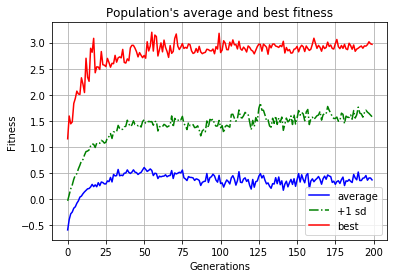

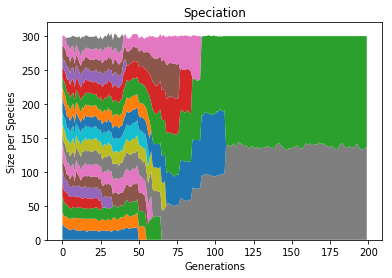

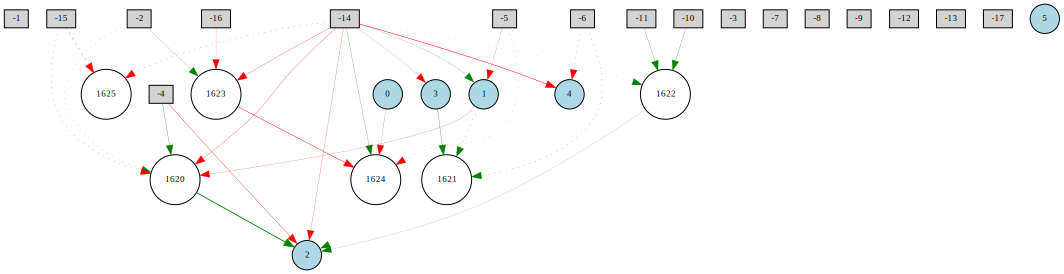

In [8]:
# This section of code prints graphical representation of the progress of the:
# Fitness per Generation
# Species size per generation
# The CTRNN configuration

import visualize
best = p.best_genome
visualize.plot_stats(stats, view = True)
visualize.plot_species(stats, view = True)
visualize.draw_net(config, best, view = True)